In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, chain
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [2]:
# Dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Explicability
import shap

In [3]:
# Import classification algorithms
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

J'ai opté pour le recall plutôt qu'une autre métrique pour une raison spécifique : en maximisant le recall, je cherche à capturer le plus grand nombre possible de joueurs prometteurs que je souhaite recruter. Bien que cela puisse entraîner le recrutement de joueurs qui ne resteront pas dans la ligue pendant 5 ans, je suis d'avis qu'une équipe de la NBA est prête à prendre des risques sur des joueurs présentant un fort potentiel, même si leur avenir est incertain. Ces joueurs ont la possibilité de rapporter considérablement au club à long terme.

# Preprocessing

In [4]:
from core_functions import extract_preprocessed_datas, score_classifier, plot_roc_auc, SEED

In [5]:
# Load dataset
datas_path = "../data/nba_logreg.csv"
df_features, labels = extract_preprocessed_datas(datas_path, 'TARGET_5Yrs', ['Name'])

In [6]:
labels = pd.Series(labels)
positive_labels = list(labels.loc[labels==1.0].index)
negative_labels = list(labels.loc[labels==0.0].index)
len(positive_labels), len(negative_labels)

(831, 509)

En raison du déséquilibre entre les classes, j'ai opté pour l'utilisation de StratifiedKFold lors de la validation croisée. Cela nous permet de répartir de manière équilibrée les différentes classes dans les différents plis. Cette considération sera prise en compte tout au long de notre étude.

In [7]:
# normalize dataset
X = MinMaxScaler().fit_transform(df_features)
X_stand = StandardScaler().fit_transform(df_features)

# Data Study

In [8]:
len(df_features), len(df_features.columns)

(1340, 19)

19 variables en tout avec 1340 joueurs, pas beaucoup de joueurs et pas beaucoup de variables.

Variables que des floatants ou des entiers.

C:\Users\antoi\AppData\Local\Temp\ipykernel_18588\1049189591.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_features.hist(bins=20, ax=ax);


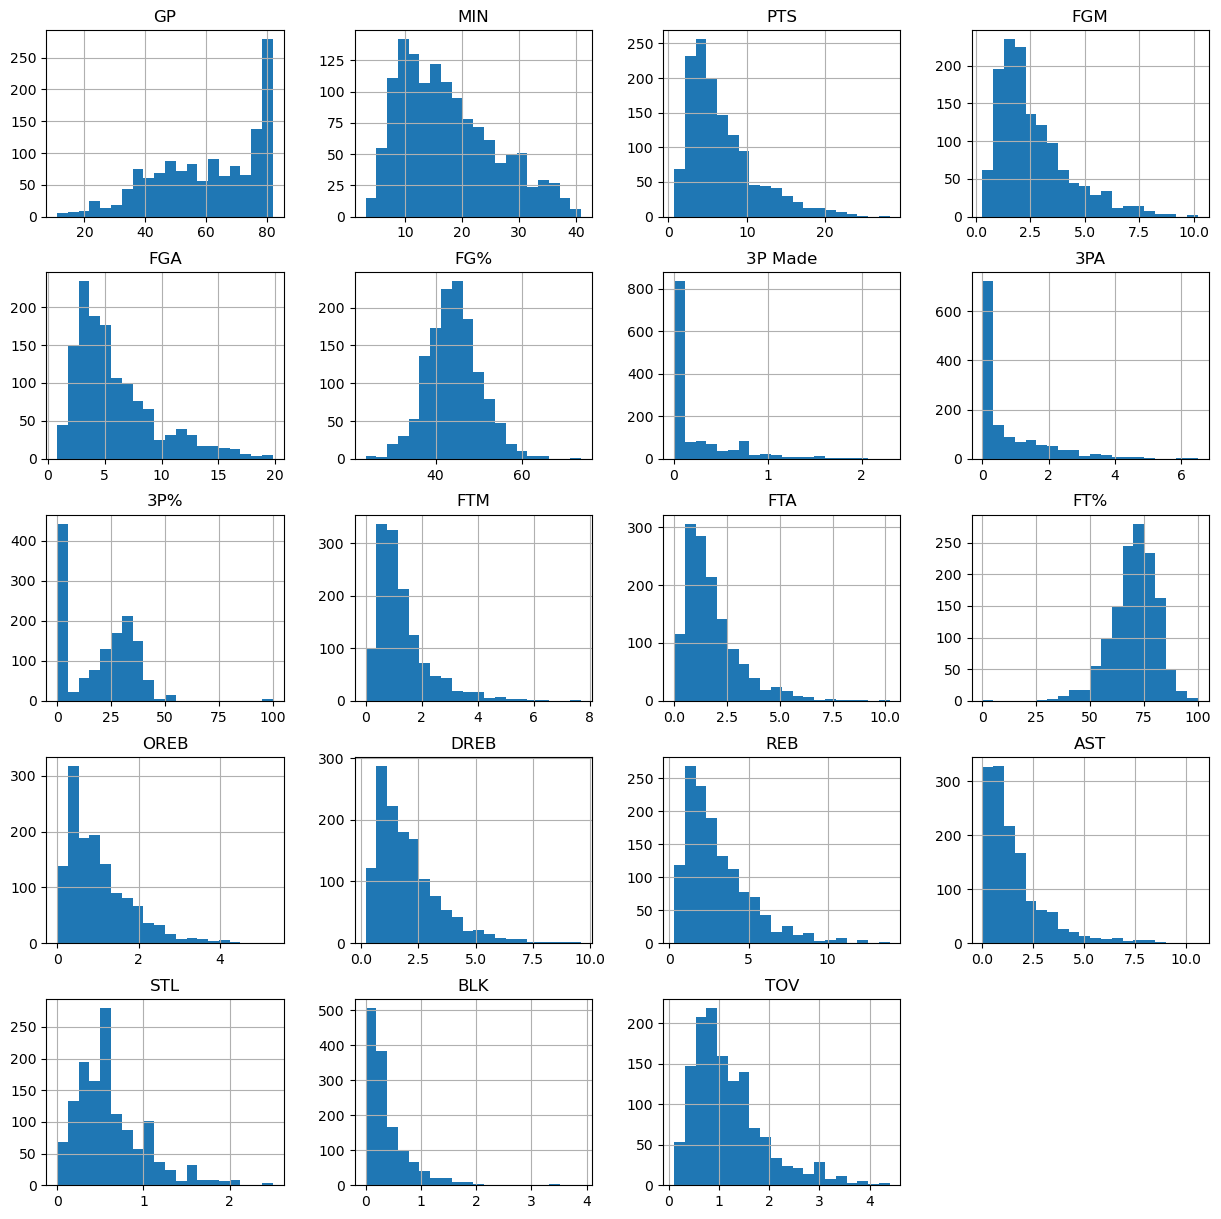

In [9]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df_features.hist(bins=20, ax=ax);

## Matrice de corrélation

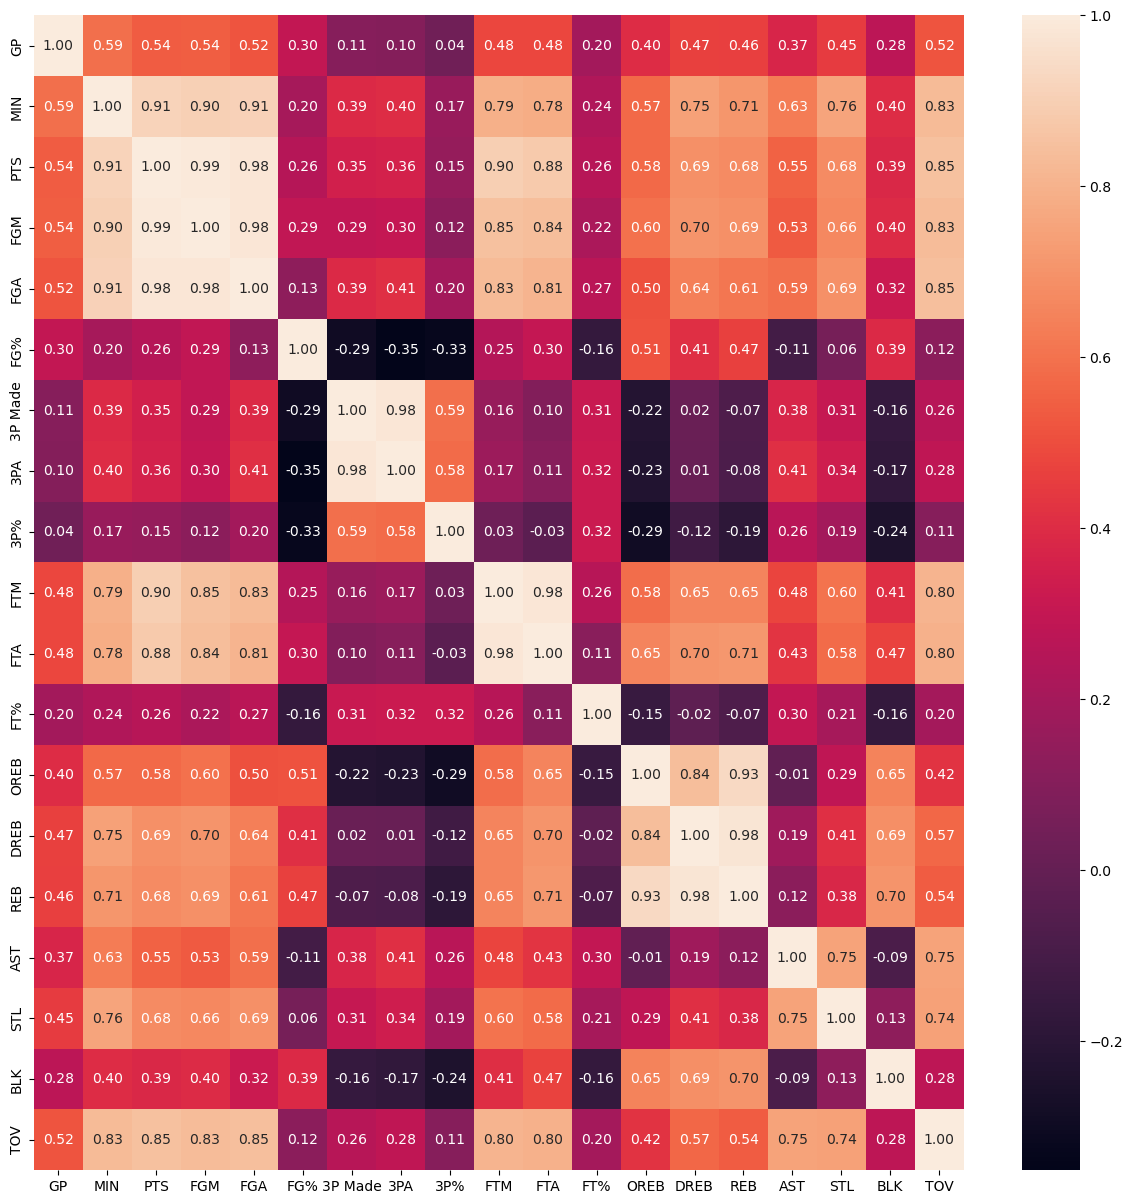

In [10]:
df_features_scaled = pd.DataFrame(X, columns=df_features.columns)

figure = plt.figure(figsize=(15, 15))
ax = figure.gca()
corr = df_features_scaled.corr()
sns.heatmap(corr, annot=True, fmt=".2f", ax=ax)
plt.show()

Des features sont très corrélées typiquement entre 'attemps' et 'made':
- 'REB' et 'DREB' et 'OREB'
- 'FTA' et 'FTM'
- '3PA' et '3P made'
- 'MIN' et 'PTS' et 'FGM' et 'FGA'

Ces corrélations parraissent assez logiques et il faut potentiellement réduire la dimension avant d'utiliser un modèle paramétrique (une régression logistique par exemple). En effet, plus on tire plus on a chance de marquer.

# Réduction de dimension

Je veux représenter graphiquement les données en deux dimensions afin d'identifier d'éventuels schémas dans la répartition des données sur un espace de dimensions réduites.

In [11]:
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

tsne = TSNE(n_components=2, random_state=SEED)
X_tsne = tsne.fit_transform(X)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=SEED)
X_umap = umap_model.fit_transform(X)

[0.54494881 0.17898565]
[18.90405472 10.83393484]


C:\Users\antoi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
def plot_reduced_2_dimensions(ax, data1, data2, colors, labels, name):
    ax.scatter(data1[:, 0], data1[:, 1], marker='o', c=colors[0], alpha=0.5, label=labels[0])
    ax.scatter(data2[:, 0], data2[:, 1], marker='o', c=colors[1], alpha=0.5, label=labels[1])
    ax.set_xlabel(f'{name} Dimension 1')
    ax.set_ylabel(f'{name} Dimension 2')
    ax.set_title(f'{name} Visualization')

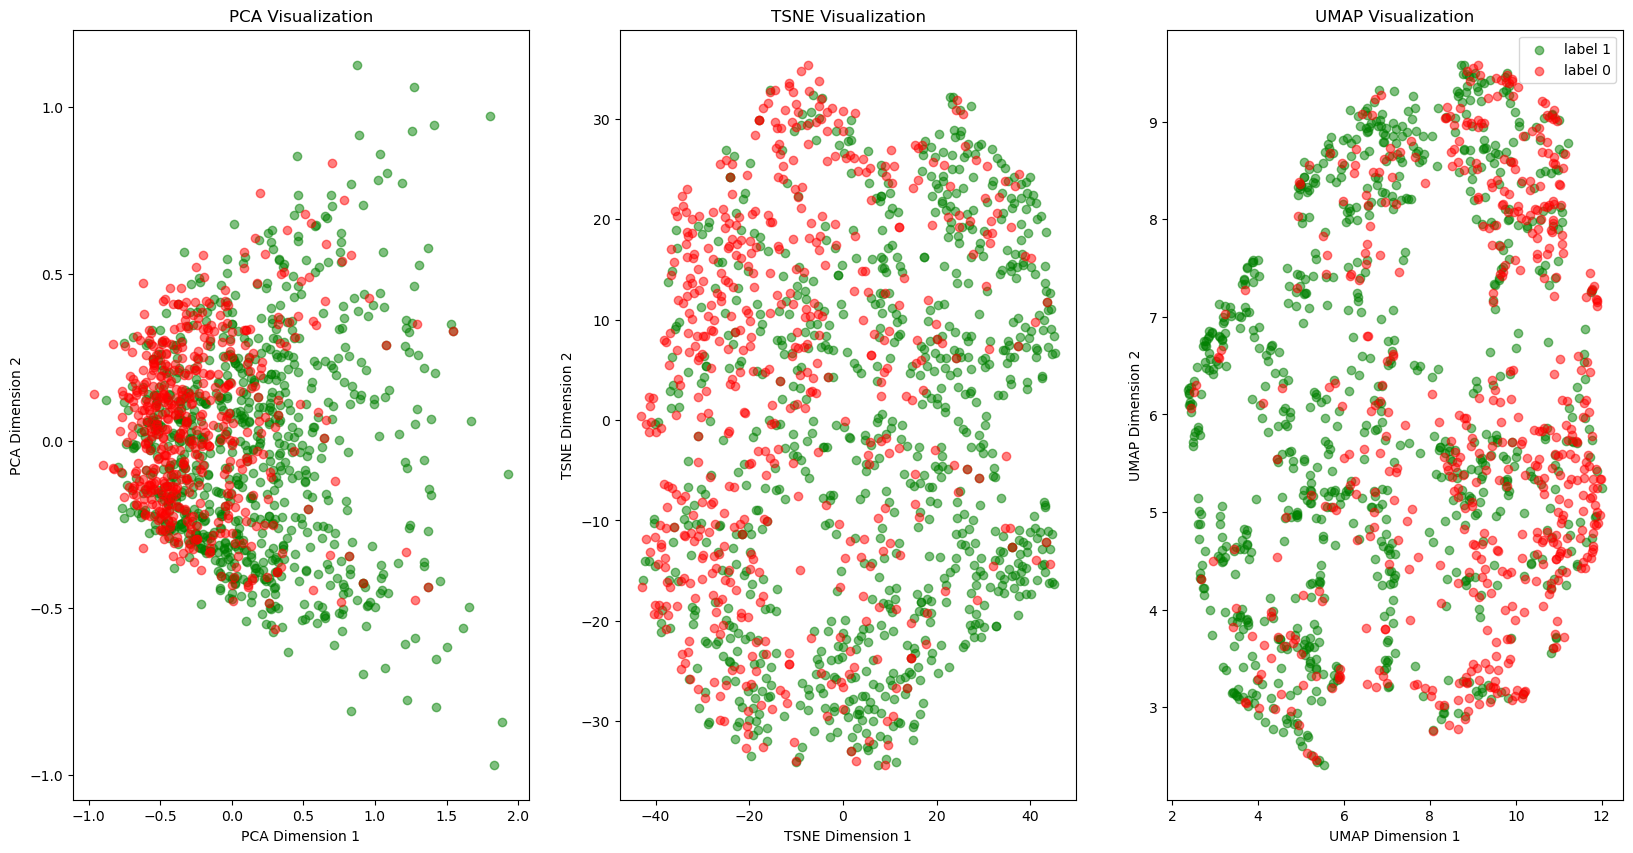

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

plot_reduced_2_dimensions(axs[0], X_pca[positive_labels], X_pca[negative_labels], ['green', 'red'], ['label 1', 'label 0'], 'PCA')

plot_reduced_2_dimensions(axs[1], X_tsne[positive_labels], X_tsne[negative_labels], ['green', 'red'], ['label 1', 'label 0'], 'TSNE')

plot_reduced_2_dimensions(axs[2], X_umap[positive_labels], X_umap[negative_labels], ['green', 'red'], ['label 1', 'label 0'], 'UMAP')

plt.legend()
plt.show();

Lors de l'observation des trois représentations en deux dimensions de nos données, il est notable que les différences entre les distributions des deux classes sont perceptibles visuellement, notamment sur la représentation UMAP. En effet, la classe 1 tend à se concentrer davantage à gauche tandis que la classe 0 se trouve plus souvent à droite. Cependant, il est important de souligner que les deux distributions se chevauchent considérablement, ce qui rend la tâche de classification non triviale en deux dimensions.

# Test de plusieurs classifieurs

Dans cette partie nous allons évaluer les performances de plusieurs algorithmes de classification :
- Régression logistique
- Support Vector Machines
- Multi Layer Perceptron
- XGBoost
- Algorithme des plus proches voisins
- Random Forest

Ces algorithmes seront optimisés avec une Optimisation Bayesienne. Leurs performances seront évaluées en Cross-validation en 3 folds sur plusieurs critères moyennés:
- Score de recall
- Courbe ROC et score AUC
- Matrice de confusion

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33)

## 1. MLP classifier
### Optimisation with Bayesian Search

In [15]:
# Define the parameter space
param_space = {
    'hidden_layer_sizes': Integer(10, 40, prior='uniform'),
    'alpha': Real(1e-3, 1e-1, 'log-uniform'),
    'learning_rate_init': Real(1e-4, 1e-2, 'log-uniform'),
    'max_iter': Integer(200, 500),
}

# Define MLP classifier
mlp = MLPClassifier(random_state=0, early_stopping=True, validation_fraction=0.1)

# Perform Bayesian optimization
bayes_search = BayesSearchCV(mlp, param_space, scoring='f1', random_state=0, refit=True)
bayes_search.fit(X, labels)

best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

Best parameters: OrderedDict([('alpha', 0.001), ('hidden_layer_sizes', 34), ('learning_rate_init', 0.0029899925631868295), ('max_iter', 200)])
Best score: 0.7742700593515653


### Cross-validation on the best MLP model

In [25]:
best_mlp_classifier = MLPClassifier(random_state=0, alpha=0.0566311861176472, hidden_layer_sizes=18, learning_rate_init=0.0013392685432232728, max_iter=400)
mlp_predict, _ = score_classifier(X, best_mlp_classifier, labels, 3)

C:\Users\antoi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[[286. 223.]
 [162. 669.]]
All recall scores: [0.7942238267148014, 0.8086642599277978, 0.8122743682310469]
Mean recall score: 0.8050541516245486


### MLP Results Study

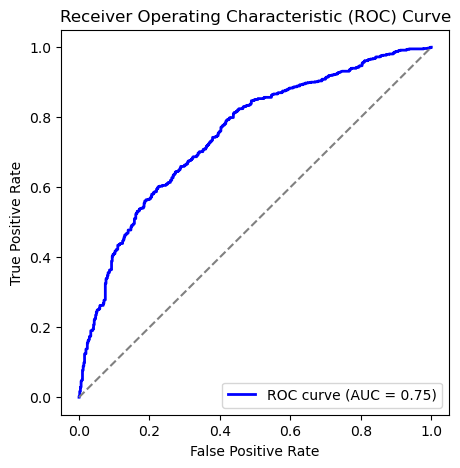

In [27]:
plot_roc_auc(mlp_predict)

In [18]:
# Plot in 2 dimensions from the errors of the MLP classifier
predict_diffs = labels - mlp_predit['predictions']
false_positive = list(predict_diffs.loc[predict_diffs == -1.0].index)
false_negative = list(predict_diffs.loc[predict_diffs == 1.0].index)

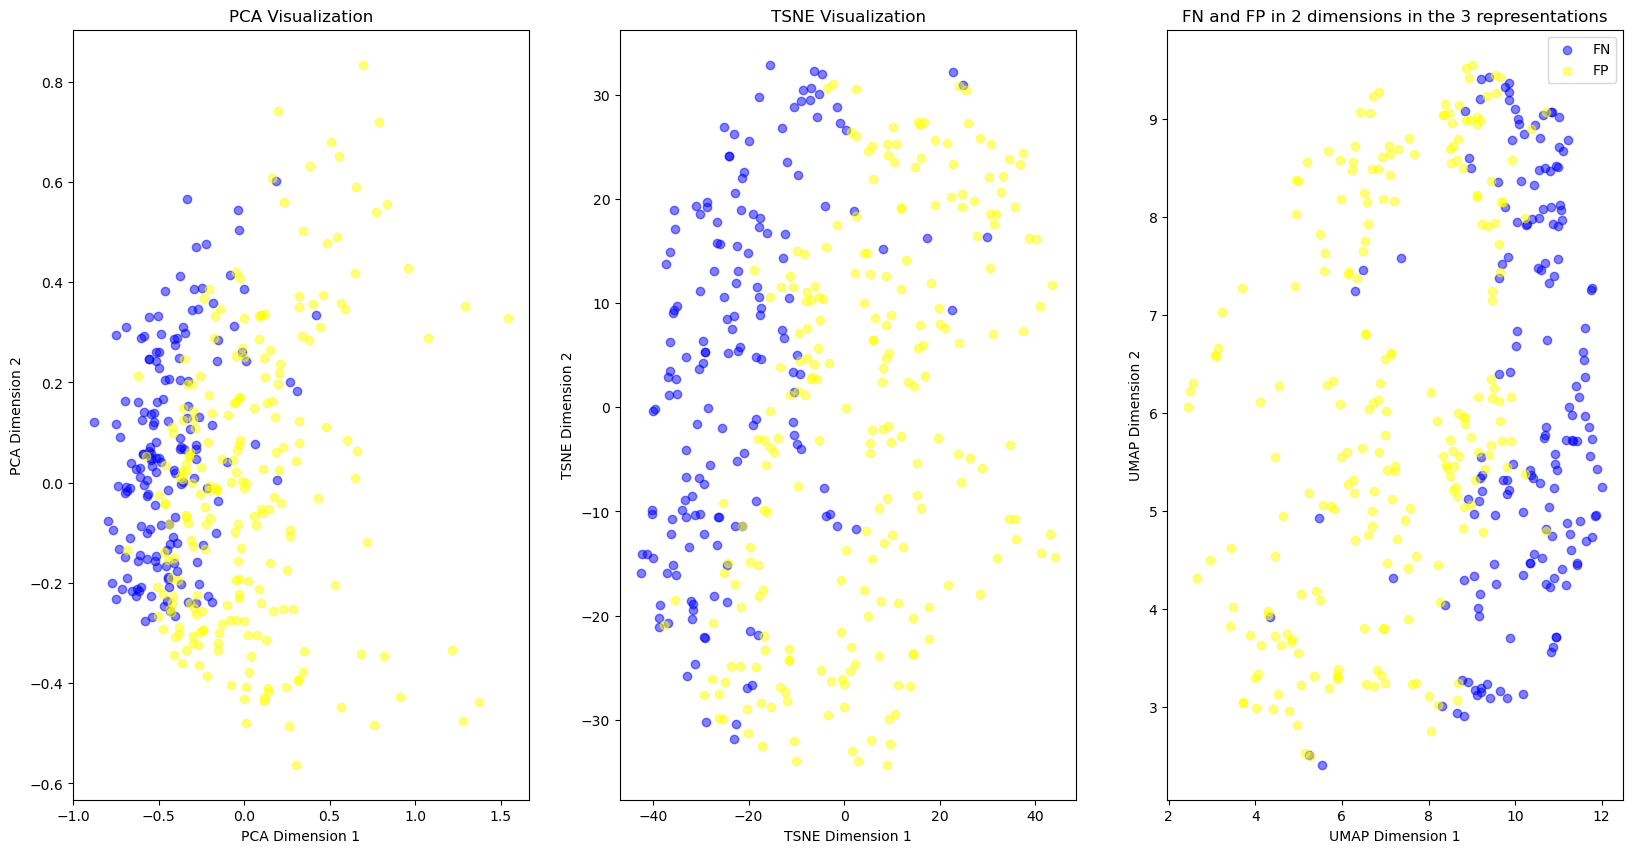

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

plot_reduced_2_dimensions(axs[0], X_pca[false_negative], X_pca[false_positive], ['blue', 'yellow'], ['FN', 'FP'], 'PCA')

plot_reduced_2_dimensions(axs[1], X_tsne[false_negative], X_tsne[false_positive], ['blue', 'yellow'], ['FN', 'FP'], 'TSNE')

plot_reduced_2_dimensions(axs[2], X_umap[false_negative], X_umap[false_positive], ['blue', 'yellow'], ['FN', 'FP'], 'UMAP')

plt.title('FN and FP in 2 dimensions in the 3 representations')
plt.legend()
plt.show();

Il est indéniable que des erreurs se produisent lorsque les points de la distribution associés au label 1 se chevauchent avec ceux de la distribution du label 0. Les faux négatifs se concentrent dans la région de gauche (UMAP), alors que le label qui leur est associé tend à se concentrer vers la droite (UMAP), ce qui signifie que ces points se trouvent davantage dans la distribution des exemples classifiés avec le label 1.

### Shap values for features explicability

In [24]:
best_mlp_classifier_shap = MLPClassifier(random_state=0, alpha=0.0566311861176472, hidden_layer_sizes=18, learning_rate_init=0.0013392685432232728, max_iter=400)
best_mlp_classifier_shap.fit(X_train, y_train);

In [31]:
test_rd_ids = [random.randint(1, X_test.shape[0]) for _ in range(50)]
explainer = shap.KernelExplainer(best_mlp_classifier_shap.predict, X_train)
shap_values = explainer.shap_values(X_test[test_rd_ids])

Using 897 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/50 [00:00<?, ?it/s]

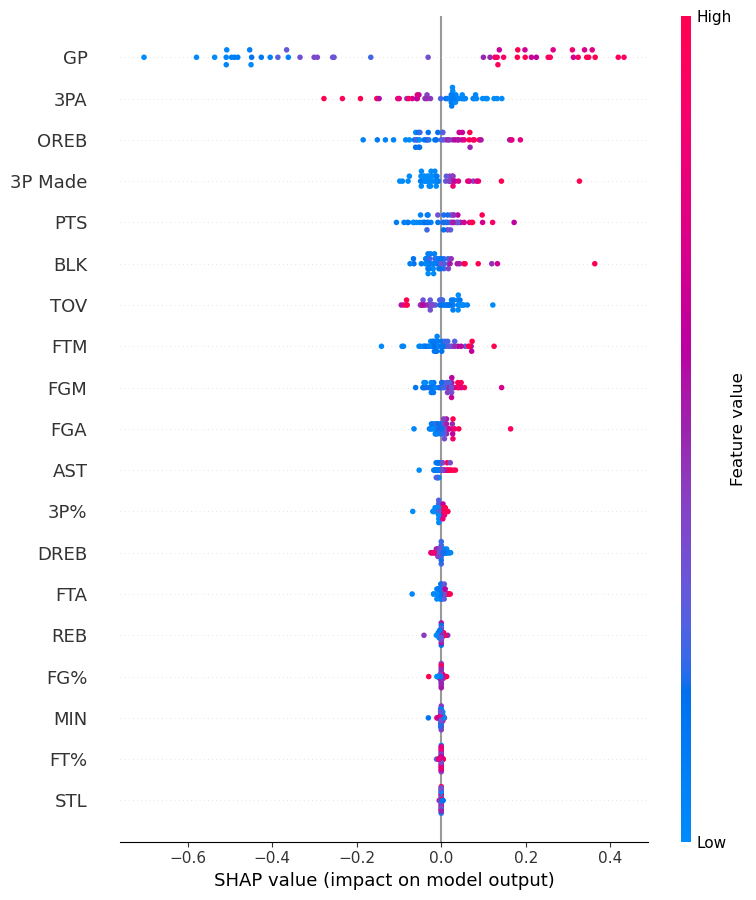

In [33]:
shap.summary_plot(shap_values, X_test[test_rd_ids], feature_names=df_features.columns)

Si on prend les 6 premières variables expliquant le mieux le label des exemples sur lesquels on a calculé les valeurs de Shapeley, on obtient:
- Games Played
- 3 Point Attempts
- Offensive Rebounds
- 3 Point Made
- Points Per Game
- Blocks

## 2. Logistic Regression

### Cross-validation with best model

In [28]:
logistic = LogisticRegression(random_state=SEED, penalty='l2', solver='liblinear')
_, _ = score_classifier(X, logistic, labels, 3, True)

[[263. 246.]
 [137. 694.]]
All recall scores: [0.8339350180505415, 0.8375451263537906, 0.8339350180505415]
Mean recall score: 0.835138387484958


## Statsmodel, statistically significant

In [31]:
logistic_stats_model = Logit(labels, X).fit()

Optimization terminated successfully.
         Current function value: 0.557056
         Iterations 7


In [32]:
logistic_stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            TARGET_5Yrs   No. Observations:                 1340
Model:                          Logit   Df Residuals:                     1321
Method:                           MLE   Df Model:                           18
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.1610
Time:                        21:33:48   Log-Likelihood:                -746.46
converged:                       True   LL-Null:                       -889.75
Covariance Type:            nonrobust   LLR p-value:                 2.740e-50
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4663      0.332      7.428      0.000       1.816       3.117
x2            -1.8671      1.249     -1.495      0.135      -4.316       0.581
x3            21.6069     23.141      0.934      0.350     -23.750      66.963
x4           -10.9568     16.976     -0.645      0.519     -44.228      22.315
x5            -1.9982      3.895     -0.513      0.608      -9.631       5.635
x6            -0.6407      0.885     -0.724      0.469      -2.375       1.094
x7             6.2054      2.992      2.074      0.038       0.342      12.069
x8            -7.9254      2.638     -3.004      0.003     -13.096      -2.755
x9             0.0699      0.509      0.137      0.891      -0.928       1.067
x10            9.7070      7.738      1.254      0.210      -5.459      24.873
x11          -13.7106      3.808     -3.600      0.000     -21.174      -6.247
x12           -1.9885      0.562     -3.540      0.000      -3.090      -0.887
x13           -3.3854      6.641     -0.510      0.610     -16.401       9.630
x14          -14.6019     11.790     -1.239      0.216     -37.710       8.506
x15           19.6627     16.963      1.159      0.246     -13.583      52.909
x16            3.1641      1.184      2.671      0.008       0.843       5.486
x17           -0.1180      0.792     -0.149      0.882      -1.670       1.434
x18            2.0416      1.037      1.968      0.049       0.008       4.075
x19           -1.4248      1.169     -1.218      0.223      -3.717       0.867
==============================================================================
"""

Features avec un coefficient de logistic regression, statistiquement non nul (p-value > 0.05):
- Games Played
- Field Goal Percent
- 3 Point Made
- Free Throw Attemps
- Free Throw Percent
- Assists

On retrouve 3 des variables identifiées comme les plus explicatives après l'utilisation de SHAP sur le MLP classifieur: Games Played, 3 Point Made, 3 Point Attempts.

### Retrained the logistic regression with significant features

In [33]:
idx_statiscally_significant = [0, 6, 7, 10, 11, 15]

In [34]:
predict_logistic_red, _ = score_classifier(X[:, idx_statiscally_significant], logistic, labels, 3, True)

[[247. 262.]
 [135. 696.]]
All recall scores: [0.8411552346570397, 0.8411552346570397, 0.8303249097472925]
Mean recall score: 0.8375451263537906


Le recall est légèrement meilleur avec ces features.

## 3. Nearest Neighbors
On trouve sans Bayesian Search le meilleurs nombre de voisin, en calculant le recall sur plusieurs modèles/

Best neighbors: 37


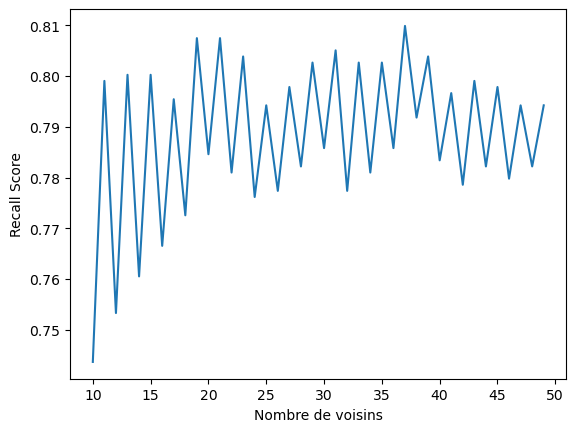

In [39]:
number_neighs = [i for i in range(10, 50)]
all_recalls = []
for nb in number_neighs:
    neigh = KNeighborsClassifier(n_neighbors=nb)
    _, recalls_neigh = score_classifier(X, neigh, labels, 3, False, printing=False)
    recall_mean = sum(recalls_neigh) / len(recalls_neigh)
    all_recalls.append(recall_mean)
print(f"Best neighbors: {number_neighs[np.argmax(all_recalls)]}")
plt.plot(number_neighs, all_recalls)
plt.ylabel('Recall Score')
plt.xlabel('Nombre de voisins')
plt.show();

In [41]:
neigh = KNeighborsClassifier(n_neighbors=number_neighs[np.argmax(all_recalls)])
_, _ = score_classifier(X, neigh, labels, 3, True)
sum(recalls_neigh) / len(recalls_neigh)

[[280. 229.]
 [158. 673.]]
All recall scores: [0.7978339350180506, 0.8122743682310469, 0.8194945848375451]
Mean recall score: 0.8098676293622141


0.7942238267148015

## Other models

In [44]:
# SVM
svm = SVC(probability=True, random_state=SEED)  # For the Voting Classifier
_, _ = score_classifier(X, svm, labels, 3, True)

[[268. 241.]
 [142. 689.]]
All recall scores: [0.8411552346570397, 0.8194945848375451, 0.8267148014440433]
Mean recall score: 0.829121540312876


In [46]:
# SVM, weighted samples
svm = SVC(probability=True, random_state=SEED, class_weight='balanced')  # For the Voting Classifier
_, _ = score_classifier(X, svm, labels, 3, True)

[[371. 138.]
 [300. 531.]]
All recall scores: [0.6353790613718412, 0.6209386281588448, 0.6606498194945848]
Mean recall score: 0.6389891696750903


Il est donc évident que l'utilisation de samples pondérés selon la distribution des classes n'est pas la méthode la plus efficace.

In [48]:
# XGBoost
xgb = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, min_samples_leaf=4, min_samples_split=2, random_state=SEED)
_, _ = score_classifier(X, xgb, labels, 3, True)

[[257. 252.]
 [153. 678.]]
All recall scores: [0.8158844765342961, 0.8122743682310469, 0.8194945848375451]
Mean recall score: 0.8158844765342961


In [50]:
# Random Forest
rf = RandomForestClassifier(max_depth=8, min_samples_split=1, min_samples_leaf=3, random_state=SEED)
_, _ = score_classifier(X, rf, labels, 3, True)

[[281. 228.]
 [160. 671.]]
All recall scores: [0.8231046931407943, 0.7906137184115524, 0.8086642599277978]
Mean recall score: 0.8074608904933814


| Model            | Cross-validation Recall Score | AUC  |
|:----------------|:-----------------------------:|------|
| SVM              |             0.829             | 0.74 |
| Logistic         |             0.838             | 0.75 |
| MLP              |             0.805             | 0.75 |
| XGBoost          |             0.816             | 0.75 |
| Nearest Neighbors|             0.794             | 0.75 |
| Random Forest    |             0.807             | 0.74 |


# Ensemble methods
En optant pour une approche d'ensemble, nous aspirons à rehausser les performances prédictives de nos modèles individuels tout en fournissant des prédictions plus stables, moins susceptibles de surajuster. Ainsi, j'ai pris la décision d'inclure tous les classifieurs entraînés dans ce processus. Nous agrégeons les probabilités prédites pour chaque classe par chaque modèle pour chaque entrée, puis sélectionnons la classe ayant la somme de probabilités la plus élevée pour cette entrée.

## Voting Classifieur

In [52]:
# Creates a Voting Classifier with the 'soft' feature
def create_evaluate_classifieur(classifieurs, voting):
    classifieurs_list = []
    for i, classi in enumerate(classifieurs):
        new_classi = (str(i), classi)
        classifieurs_list.append(new_classi)
    voting = VotingClassifier(estimators=classifieurs_list, voting=voting)
    _, recalls_voting = score_classifier(X, voting, labels, 3, False, printing=False)
    return recalls_voting

In [53]:
# Create all possible combinations of classifiers to test them all
classifiers = [svm, neigh, xgb, rf, logistic, mlp]

all_combinations = []
for r in range(1, len(classifiers) + 1):
    all_combinations.extend(combinations(classifiers, r))

all_combinations = [list(comb) for comb in all_combinations]
nb_classi = [len(combi) for combi in all_combinations]

In [54]:
# Get Recall score for each combination of classifiers
all_recalls = [[] for i in range(len(np.unique(nb_classi)))]

for i, combination in enumerate(all_combinations):
    new_recalls = create_evaluate_classifieur(combination, 'soft')
    new_recall = sum(new_recalls) / len(new_recalls)
    all_recalls[len(combination) - 1].append(new_recall)

In [55]:
# Display the best combinations
actual_combi = 0
for i, recalls in enumerate(all_recalls):
    ind = np.argmax(recalls)
    print(f"Best combination for {i+1} calssifiers, recall score : {recalls[ind]} : {all_combinations[ind + actual_combi]}")
    actual_combi += len(recalls)

Best combination for 1 calssifiers, recall score : 0.835138387484958 : [LogisticRegression(random_state=0, solver='liblinear')]
Best combination for 2 calssifiers, recall score : 0.8363417569193743 : [LogisticRegression(random_state=0, solver='liblinear'), MLPClassifier(early_stopping=True, random_state=0)]
Best combination for 3 calssifiers, recall score : 0.8279181708784598 : [GradientBoostingClassifier(learning_rate=0.05, max_depth=2, min_samples_leaf=4,
                           random_state=0), LogisticRegression(random_state=0, solver='liblinear'), MLPClassifier(early_stopping=True, random_state=0)]
Best combination for 4 calssifiers, recall score : 0.8255114320096268 : [GradientBoostingClassifier(learning_rate=0.05, max_depth=2, min_samples_leaf=4,
                           random_state=0), RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=1,
                       random_state=0), LogisticRegression(random_state=0, solver='liblinear'), MLPClassifier(ea

On peut donc essayer de conclure que les classifieurs les plus importants pour une prédiction ensembliste sont dans l'ordre :
1. Régression logistique
2. MLP classifieur
3. XGBoost classifieur
4. Random Forest classifieur
5. Plus Proches voisins 
6. SVM

Le meilleur score de recall est obtenu avec la combinaison des prédictions de la régression logistique et du MLP avec 0.836 en cross-validation à 3 folds.

L'avantage en plus d'améliorer nos performances de classification, cette méthode ensembliste permet de rendre notre plus robuste et limiter la variance sur les prédictions.

In [61]:
# Best voting classifier
voting = VotingClassifier(estimators=[('logistic', logistic), ('mlp', mlp)], voting='soft')
voting_predict, _ = score_classifier(X, voting, labels, 3)

[[267. 242.]
 [136. 695.]]
All recall scores: [0.8231046931407943, 0.8447653429602888, 0.8411552346570397]
Mean recall score: 0.8363417569193743


# Conclusions

1. La régression logistique, entraînée sur les caractéristiques significatives, demeure le classifieur le plus performant en termes de prédiction. Le Voting Classifier, quant à lui, se rapproche de ses performances, mais il semble nécessiter des valeurs plus robustes pour améliorer davantage ses résultats.

2. Une analyse d'explicabilité a été réalisée pour mieux comprendre les données, en identifiant notamment quelles caractéristiques pourraient être plus déterminantes que d'autres. Trois caractéristiques se distinguent particulièrement : les parties jouées, les tirs à trois points réussis et les tentatives de tirs à trois points. En revanche, la caractéristique du nombre de vols de balles semble avoir très peu d'impact sur la tâche de classification.

3. L'optimisation par recherche bayésienne ne permet pas d'explorer différentes tailles d'architectures pour le MLP.

4. Même en deux dimensions, il est facile de remarquer la complexité de la tâche à accomplir.

# Possibles améliorations

1. Il est probable que le MLP puisse être optimisé en ajoutant des couches, en reconfigurant son architecture et en incorporant des techniques telles que le dropout, par exemple.

2. Explorer une gamme plus large de transformations des données avant de les soumettre au modèle peut être bénéfique.

3. Il pourrait être envisagé de générer davantage de données pour enrichir le jeu d'entraînement des modèles.

4. Considérer d'autres approches pour gérer les données manquantes pourrait être une piste d'amélioration.

5. Explorer des ensembles de données plus sophistiqués, comme le Bagging, pourrait également être une stratégie prometteuse.